In [249]:
import nest
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import importlib
import constants

importlib.reload(constants)
from constants import *

nest.ResetKernel()

In [250]:
plt.ion()

In [251]:
POP_SIZE_E

25

In [252]:
def create_populations():
    """
    Create populations of excitatory and inhibitory neurons with spatial distribution

    Returns:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """
    E_neuron_params = {
        "E_L": E_NEURON_E_L,
        "C_m": E_NEURON_C_M,
        "tau_m": E_NEURON_TAU_M,
        "t_ref": E_NEURON_T_REF,
        "V_th": E_NEURON_V_TH,
        "V_reset": E_NEURON_V_RESET,
        "tau_syn_ex": E_NEURON_TAU_SYN_EX,
        "tau_syn_in": E_NEURON_TAU_SYN_IN
    }

    I_neuron_params = {
        "E_L": I_NEURON_E_L,
        "C_m": I_NEURON_C_M,
        "tau_m": I_NEURON_TAU_M,
        "t_ref": I_NEURON_T_REF,
        "V_th": I_NEURON_V_TH,
        "V_reset": I_NEURON_V_RESET,
        "tau_syn_ex": I_NEURON_TAU_SYN_EX,
        "tau_syn_in": I_NEURON_TAU_SYN_IN
    }

    pop_size_E = POP_SIZE_E
    pop_size_I = POP_SIZE_I

    nest.CopyModel("iaf_psc_alpha", "exc_iaf_psc_alpha")
    nest.SetDefaults("exc_iaf_psc_alpha", E_neuron_params)

    nest.CopyModel("iaf_psc_alpha", "inh_iaf_psc_alpha")
    nest.SetDefaults("inh_iaf_psc_alpha", I_neuron_params)

    pos_e = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )
    pos_i = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )

    layer_e = nest.Create("exc_iaf_psc_alpha", n=pop_size_E, positions=pos_e)
    layer_i = nest.Create("inh_iaf_psc_alpha", n=pop_size_I, positions=pos_i)
    
    return layer_e, layer_i

def get_positions(neurons) -> np.ndarray:
    """
    Get the positions of a list of neurons.
    (Assumes that nest.GetStatus(neurons, 'positions') returns a list of positions.)
    """
    return np.array(nest.GetPosition(neurons))

def get_positions_dict(layer_e, layer_i):
    """
    Returns dictionaries mapping neuron id -> position for excitatory and inhibitory populations.
    """
    positions_exc = {
        neuron: pos for neuron, pos in zip(layer_e, get_positions(layer_e))
    }
    positions_inh = {
        neuron: pos for neuron, pos in zip(layer_i, get_positions(layer_i))
    }
    return positions_exc, positions_inh

def spatial_distribution(layer_e, layer_i, fig=None, ax=None): 
    """
    Plot the spatial distribution of excitatory and inhibitory neurons

    Args:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    Returns:
        fig (matplotlib.figure.Figure): Figure object
        ax1 (matplotlib.axes.Axes): Axes object
        ax2 (matplotlib.axes.Axes): Axes object
    """

    positions_e = get_positions(layer_e)
    positions_i = get_positions(layer_i)

    if fig is None or ax is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    else:
        ax1, ax2 = ax
    ax1.scatter(positions_e[:, 0], positions_e[:, 1], c='blue', label='Excitatory')
    ax1.scatter(positions_i[:, 0], positions_i[:, 1], c='red', label='Inhibitory')
    ax1.set_title("Spatial Distribution of Neurons")
    ax1.legend()

    
    fig.tight_layout()
    
    return fig, ax1, ax2

def synapse_model(model_type: str):
    """
    Set up and return a synapse model based on type.

    Args:
        model_type (str): "short" or "long".
    Returns:
        (str) The name of the synapse model or None if type is not recognized.
    """
    # Define parameters for short-range synapses
    short_range_syn_params = {
        "U": 0.8,
        "tau_rec": 200.0,
        "tau_fac": 50.0
    }
    nest.CopyModel("tsodyks_synapse", "short_range_synapse")
    nest.SetDefaults("short_range_synapse", short_range_syn_params)

    # Define parameters for long-range synapses
    long_range_syn_params = {
        "U": 0.3,
        "tau_rec": 50.0,
        "tau_fac": 100.0,
    }
    nest.CopyModel("tsodyks_synapse", "long_range_synapse")
    nest.SetDefaults("long_range_synapse", long_range_syn_params)

    if model_type == "short":
        return "short_range_synapse"
    elif model_type == "long":
        return "long_range_synapse"
    else:
        return None

def connect_pop_base(layer_e, layer_i, fig, ax:tuple):
    """
    Connect the populations with specific spatial synaptic rules

    Args:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """
    figT, ax1, ax2 = spatial_distribution(layer_e, layer_i, fig, ax)

    delay_connection = DELAY_CONNECTION
    g = G  # ratio inhibitory weight to excitatory weight

    # Define a distance‐dependent connection rule
    distribution = nest.spatial_distributions.gaussian(nest.spatial.distance, std=GAUSSIAN_STD)
    conndict = {
        "rule": "pairwise_bernoulli",
        "p": nest.logic.conditional(distribution > DISTRIBUTION_THRESHOLD, distribution, 0),
        "mask": {"circular": {"radius": MASK_RADIUS}},
    }

    # Copy a generic synapse model
    nest.CopyModel("tsodyks_synapse", "synapse")

    # Define weights
    exc_weight = 2.0
    inh_weight = 1.0

    # Make connections
    nest.Connect(layer_e, layer_i, conndict, syn_spec={"synapse_model": "synapse", "weight": exc_weight})
    nest.Connect(layer_i, layer_e, conndict, syn_spec={"synapse_model": "synapse", "weight": -inh_weight})
    nest.Connect(layer_e, layer_e, conndict, syn_spec={"synapse_model": "synapse", "weight": exc_weight})
    nest.Connect(layer_i, layer_i, conndict, syn_spec={"synapse_model": "synapse", "weight": -inh_weight})

    connections = nest.GetConnections(synapse_model="synapse")
    print(f"Total synapses (base): {len(connections)}")
    find_plot_connections(connections, layer_e, layer_i, figT, ax1, ax2)

def connect_pop_tsodyks(layer_e, layer_i, fig, ax:tuple):
    """
    Connects populations with distance-dependent synapse models (Tsodyks for short-range, static for long-range).
    """
    
    figT, ax1, ax2 = spatial_distribution(layer_e, layer_i, fig, ax)

    # Define connection rules
    distribution_short = nest.spatial_distributions.gaussian(nest.spatial.distance, std=0.6)
    short_range_rule = {
        "rule": "pairwise_bernoulli",
        "p": nest.logic.conditional(distribution_short > 0.2, distribution_short, 0),
        "mask": {"circular": {"radius": 0.5}}
    }
    long_range_rule = {
        "rule": "fixed_total_number",
        "N": int(0.1 * len(layer_e) * len(layer_i))
    }

    # Define synapse parameters
    short_range_syn_params = {
        "U": 0.8,
        "tau_rec": 200.0,
        "tau_fac": 50.0,
        "weight": -1.0
    }
    long_range_syn_params = {
        "U": 0.3,
        "tau_rec": 50.0,
        "tau_fac": 100.0,
        "weight": 0.5
    }
    nest.CopyModel("tsodyks_synapse", "short_syn", short_range_syn_params)
    nest.CopyModel("tsodyks_synapse", "long_syn", long_range_syn_params)

    # Make connections with both synapse models
    nest.Connect(layer_e, layer_i, conn_spec=short_range_rule,
                 syn_spec={"synapse_model": "short_syn", "weight": -1.0})
    nest.Connect(layer_e, layer_i, conn_spec=long_range_rule,
                 syn_spec={"synapse_model": "long_syn", "weight": 0.5})
    nest.Connect(layer_i, layer_e, conn_spec=short_range_rule,
                 syn_spec={"synapse_model": "short_syn", "weight": -1.0})
    nest.Connect(layer_i, layer_e, conn_spec=long_range_rule,
                 syn_spec={"synapse_model": "long_syn", "weight": 0.5})
    nest.Connect(layer_i, layer_i, conn_spec=short_range_rule,
                 syn_spec={"synapse_model": "short_syn", "weight": -1.0})
    nest.Connect(layer_i, layer_i, conn_spec=long_range_rule,
                 syn_spec={"synapse_model": "long_syn", "weight": 0.5})
    nest.Connect(layer_e, layer_e, conn_spec=short_range_rule,
                 syn_spec={"synapse_model": "short_syn", "weight": -1.0})
    nest.Connect(layer_e, layer_e, conn_spec=long_range_rule,
                 syn_spec={"synapse_model": "long_syn", "weight": 0.5})

    num_short = len(nest.GetConnections(synapse_model="short_syn"))
    num_long = len(nest.GetConnections(synapse_model="long_syn"))
    print(f"Synapses with STP: {num_short}")
    print(f"Synapses without STP: {num_long}")

    connections_short = nest.GetConnections(synapse_model="short_syn")
    connections_long = nest.GetConnections(synapse_model="long_syn")
    all_connections = [connections_short, connections_long]
    find_plot_connections(all_connections, layer_e, layer_i, figT, ax1, ax2)
    # return layer_e, layer_i

def find_positions(layer_e, layer_i):
    positions_exc = [(i + 1, pos) for i, pos in enumerate(layer_e.spatial["positions"])]
    start_index_inh = len(positions_exc) + 1 
    positions_inh = [(i + start_index_inh, pos) for i, pos in enumerate(layer_i.spatial["positions"])]
    # print(positions_exc)
    # print(positions_inh)
    
    positions_exc_dict = {neuron_id: pos for neuron_id, pos in positions_exc}
    positions_inh_dict = {neuron_id: pos for neuron_id, pos in positions_inh}

    return positions_exc_dict, positions_inh_dict

    
def find_plot_connections(connections, layer_e, layer_i, fig, ax1, ax2):
    """
    Visualize the connections between the neurons and plot the connectivity matrix

    Args:
        connections (list): List of connections
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
        fig (matplotlib.figure.Figure): Figure object
        ax1 (matplotlib.axes.Axes): Axes object
        ax2 (matplotlib.axes.Axes): Axes object
    """
    # source_node = int(input("Enter the source node: "))
    if isinstance(connections, list):
        all_connections = []
        for conn_collection in connections:
            all_connections.extend(list(conn_collection))  # Convert SynapseCollection to list of dictionaries
    else:
        all_connections = list(connections)  # Convert SynapseCollection to list of dictionaries
    
    source_node = 5
    center_neuron = nest.FindCenterElement(layer_e)
    cn_coords = center_neuron.spatial['positions']
   
    positions_exc, positions_inh = find_positions(layer_e, layer_i)
    # print(positions_exc_dict)
    # print(positions_inh_dict)

    source_pos = positions_exc.get(source_node) or positions_inh.get(source_node)
    if source_pos is None:
        print(f"Source node {source_node} not found in the network.")
    else:
        ax1.scatter(source_pos[0], source_pos[1], c='purple', label=f'Source Node {source_node}')

    for conn in all_connections:
        if conn.get("source") == source_node:
            target_node = conn.get("target")
            target_pos = positions_exc.get(target_node) or positions_inh.get(target_node)
            if target_pos is not None:
                ax1.plot([source_pos[0], target_pos[0]],
                         [source_pos[1], target_pos[1]],
                         c='black', alpha=0.2)

    fig.tight_layout()
    plot_connectivity_matrix(len(layer_e) + len(layer_i), all_connections, ax2)
    plt.show()

def plot_connectivity_matrix(total_neurons, connection_details, ax):
    """
    Plot the connectivity matrix of the network

    Args:
    """
    weight_matrix = np.zeros((total_neurons, total_neurons))
    for conn in connection_details:
        # Adjust for Python 0-indexing (assumes neuron IDs start at 1)
        source = conn.get("source") - 1
        target = conn.get("target") - 1
        weight = conn.get("weight")
        weight_matrix[source, target] = weight

    print(weight_matrix)
    sns.heatmap(weight_matrix, cmap='viridis', ax=ax)

def create_patterned_input(layer_e, baseline_rate=50, active_rate=150):
    """
    Create a Poisson generator to simulate patterned input to the excitatory neurons
    """
    total_neurons = len(layer_e)
    grid_dim = int(np.sqrt(total_neurons))
    pattern = np.zeros((grid_dim, grid_dim))
    print(pattern.shape)
    pattern[0:2, 0:2] = 1 
    pattern[2:4, 2:4] = 1 
    pattern_flat = pattern.flatten()
    active_neurons = np.where(pattern_flat == 1)[0]
    print(pattern)
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    ax[0].imshow(pattern, cmap='viridis')
    ax[0].set_title("Patterned Input")
    ax[1].plot(pattern_flat)
    ax[1].set_title("Flattened Pattern")

    rates = baseline_rate + pattern_flat * (active_rate - baseline_rate)
    
    print(active_neurons)
    for idx in range(len(rates)):
        print(f"Neuron {layer_e[idx]}: Rate = {rates[idx]} Hz")
    
    ax[2].plot(rates)
    ax[2].set_title("Firing Rates")
    plt.show()

    patterned_inputs = nest.Create("poisson_generator", len(layer_e))

    for idx, rate in enumerate(rates):
        nest.SetStatus(patterned_inputs[idx], {"rate": rate})

    # Connect each poisson generator to the corresponding neuron
    nest.Connect(patterned_inputs, layer_e, syn_spec={"weight": 10.0, "delay": 1.5})

def create_thalamic_input(layer_e):
    """
    Create a Poisson generator to simulate thalamic input to the excitatory neurons
    """
    thalamic_input = nest.Create("poisson_generator", params={"rate": THALAMIC_INPUT_FIRING_RATE})
    nest.Connect(thalamic_input, layer_e, syn_spec={"weight": THALAMIC_INPUT_WEIGHT, "delay": THALAMIC_INPUT_DELAY}) 

def recording_devices(layer_e, layer_i):
    """
    Connect recording devices
    """
    sr_e = nest.Create("spike_recorder")
    nest.Connect(layer_e, sr_e)
    sr_i = nest.Create("spike_recorder")
    nest.Connect(layer_i, sr_i)

    multimeter_e = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
    multimeter_i = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
    nest.Connect(multimeter_e, layer_e)
    nest.Connect(multimeter_i, layer_i)

    return multimeter_e, multimeter_i, sr_e, sr_i

def plot_pattern_output(sr_e, sr_i, layer_e):
    spike_events_e = nest.GetStatus(sr_e, "events")[0]
    spike_events_i = nest.GetStatus(sr_i, "events")[0]

    senders_e = spike_events_e["senders"]
    sim_time = nest.GetKernelStatus()["biological_time"]
    firing_rates = np.zeros(len(layer_e))
    
    # Calculate firing rate per neuron (in Hz)
    for i, neuron in enumerate(layer_e):
        firing_rates[i] = np.sum(senders_e == neuron) / (sim_time / 1000.0)
    
    grid_dim = int(np.sqrt(len(layer_e)))
    firing_rate_map = firing_rates.reshape((grid_dim, grid_dim))
    plt.imshow(firing_rate_map, cmap='viridis')
    plt.title("Spatial Firing Rate Map")
    plt.colorbar(label='Firing Rate (Hz)')
    plt.show()

    return firing_rates

def plot_spikes(sr_e, sr_i):
    spike_events_e = nest.GetStatus(sr_e, "events")[0]
    spike_events_i = nest.GetStatus(sr_i, "events")[0]
    
    senders_e = spike_events_e["senders"]
    times_e = spike_events_e["times"]
    senders_i = spike_events_i["senders"]
    times_i = spike_events_i["times"]

    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
    ax.scatter(times_e, senders_e, s=1, label="Excitatory", color="red")
    ax.scatter(times_i, senders_i, s=1, label="Inhibitory", color="blue")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Neuron ID")
    ax.legend()
    plt.show()

def test_plotConnMat(layer_e,layer_i):
    """ brief function to plot only the network connections"""

    filtered_connections = [
        conn for conn in nest.GetConnections()
        if conn.get("weight") not in [10.0, 1.0]]
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    plot_connectivity_matrix(len(layer_e) + len(layer_i), filtered_connections, ax)

def monitorConnectionEvolution(layer_e, layer_i, connection_model, n_connections = 1, begin = 0, steps = 50, plots = 3):
    """
    Monitors the evolution of connections in a neural network ion.
    This function simulates the neural network for a given number of steps and 
    plots the connectivity matrix at specified intervals.
    Parameters:
    layer_e (list): List of excitatory neurons.
    layer_i (list): List of inhibitory neurons.
    begin (int, optional): time before starting to monitor.
    steps (int, optional): Number of simulation steps between each plot. Default is 50.
    plots (int, optional): Number of plots to generate. Default is 3.
    """
    conn1, conn2 = connection_model
    nest.set_verbosity("M_WARNING")
    nest.Simulate(begin)
    connections1 = nest.GetConnections(synapse_model=conn1)
    connections2 = nest.GetConnections(synapse_model=conn2)
    if n_connections == 1:
        _, axes = plt.subplots(1, plots, figsize=(22, 6))
    else:
        _, axes = plt.subplots(n_connections ,plots, figsize=(22, 6))

    for i, axs in enumerate(axes):
        nest.Simulate(steps)
        for ax in axs:
            if n_connections == 1:
                plot_connectivity_matrix(len(layer_e) + len(layer_i), connections1, ax)
            else:
                if i == 0:
                    plot_connectivity_matrix(len(layer_e) + len(layer_i), connections1, ax)
                else:
                    plot_connectivity_matrix(len(layer_e) + len(layer_i), connections2, ax)
                    current_time = nest.GetKernelStatus()['biological_time']
                    ax.set_title(f"Time: {current_time} ms")
    nest.set_verbosity("M_INFO")


def monitor_synaptic_strength(pre_neurons, post_neurons, synapse_model, interval=50, total_time=1000):
    """
    Monitors and plots the effective synaptic strength over time.

    Parameters:
    pre_neurons (list): List of presynaptic neuron IDs.
    post_neurons (list): List of postsynaptic neuron IDs.
    synapse_model (str): The synapse model.
    interval (int): Time interval (in ms) between measurements.
    total_time (int): Total simulation time (in ms).
    """
    if isinstance(synapse_model, list):
        connections = []
        for model in synapse_model:
            connections.extend(list(nest.GetConnections(synapse_model=model)))
    else:
        connections = list(nest.GetConnections(synapse_model=synapse_model))

    effective_weights = []

    for t in range(0, total_time, interval):
        nest.Simulate(interval)
        total_effective_weight = 0
        for conn in connections:
            # Assume GetStatus returns a dictionary with keys 'weight', 'u', and 'x'
            status = nest.GetStatus([conn], keys=['weight', 'u', 'x'])[0]
            w = status['weight']
            u = status['u']
            x = status['x']
            effective_weight = u * x * w
            total_effective_weight += effective_weight
        average_effective_weight = total_effective_weight / len(connections)
        effective_weights.append(average_effective_weight)

    times = list(range(0, total_time, interval))
    plt.plot(times, effective_weights)
    plt.xlabel('Time (ms)')
    plt.ylabel('Average Effective Synaptic Strength')
    plt.title('Synaptic Strength Dynamics')
    plt.show()


def create_and_simulate():
    pass

Total synapses (base): 617
[[ 2.  0.  0. ...  0.  0.  0.]
 [ 0.  2.  2. ...  2.  2.  0.]
 [ 0.  2.  2. ...  0.  0.  0.]
 ...
 [ 0. -1.  0. ... -1. -1.  0.]
 [ 0. -1.  0. ... -1. -1.  0.]
 [ 0.  0.  0. ...  0. -1. -1.]]


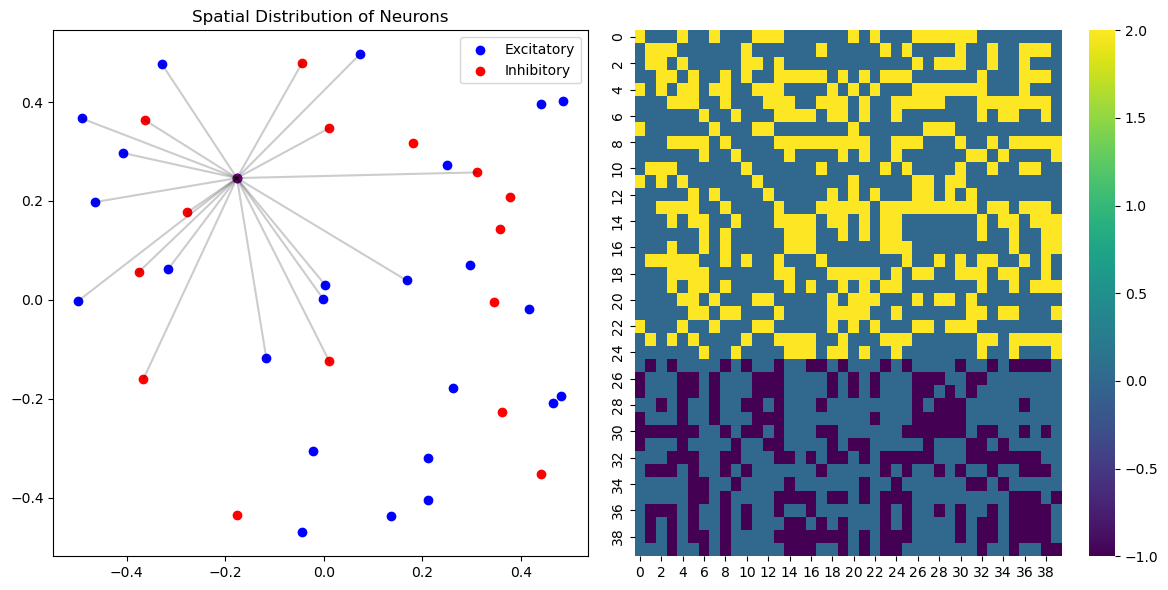

(5, 5)
[[1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]
[ 0  1  5  6 12 13 17 18]
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=1, last=1): Rate = 150.0 Hz
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=2, last=2): Rate = 150.0 Hz
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=3, last=3): Rate = 50.0 Hz
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=4, last=4): Rate = 50.0 Hz
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=5, last=5): Rate = 50.0 Hz
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=6, last=6): Rate = 150.0 Hz
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=7, last=7): Rate = 150.0 Hz
Neuron NodeCollection(met

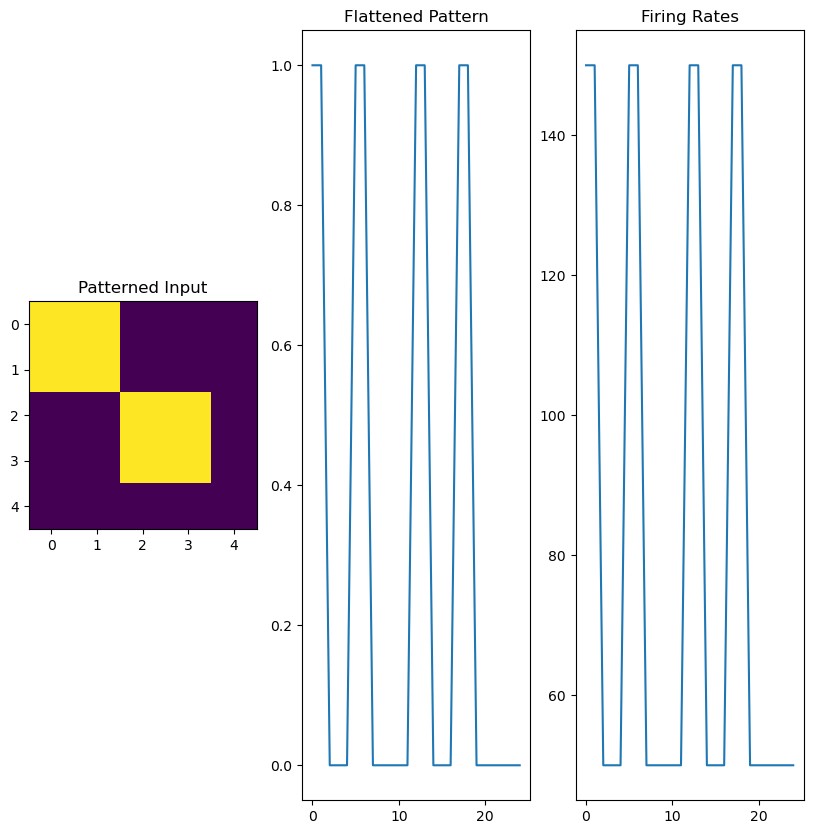


Feb 11 18:04:16 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.

Feb 11 18:04:16 NodeManager::prepare_nodes [Info]: 
    Preparing 69 nodes for simulation.

Feb 11 18:04:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 69
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Feb 11 18:04:17 SimulationManager::run [Info]: 
    Simulation finished.


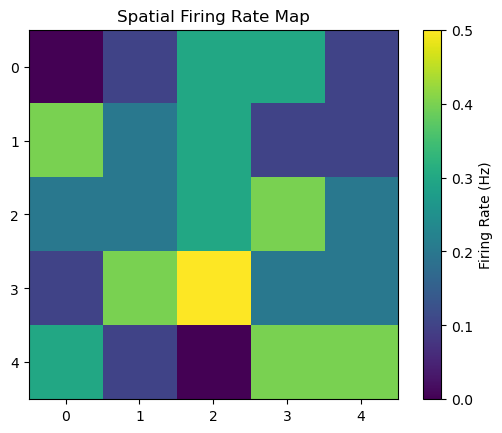

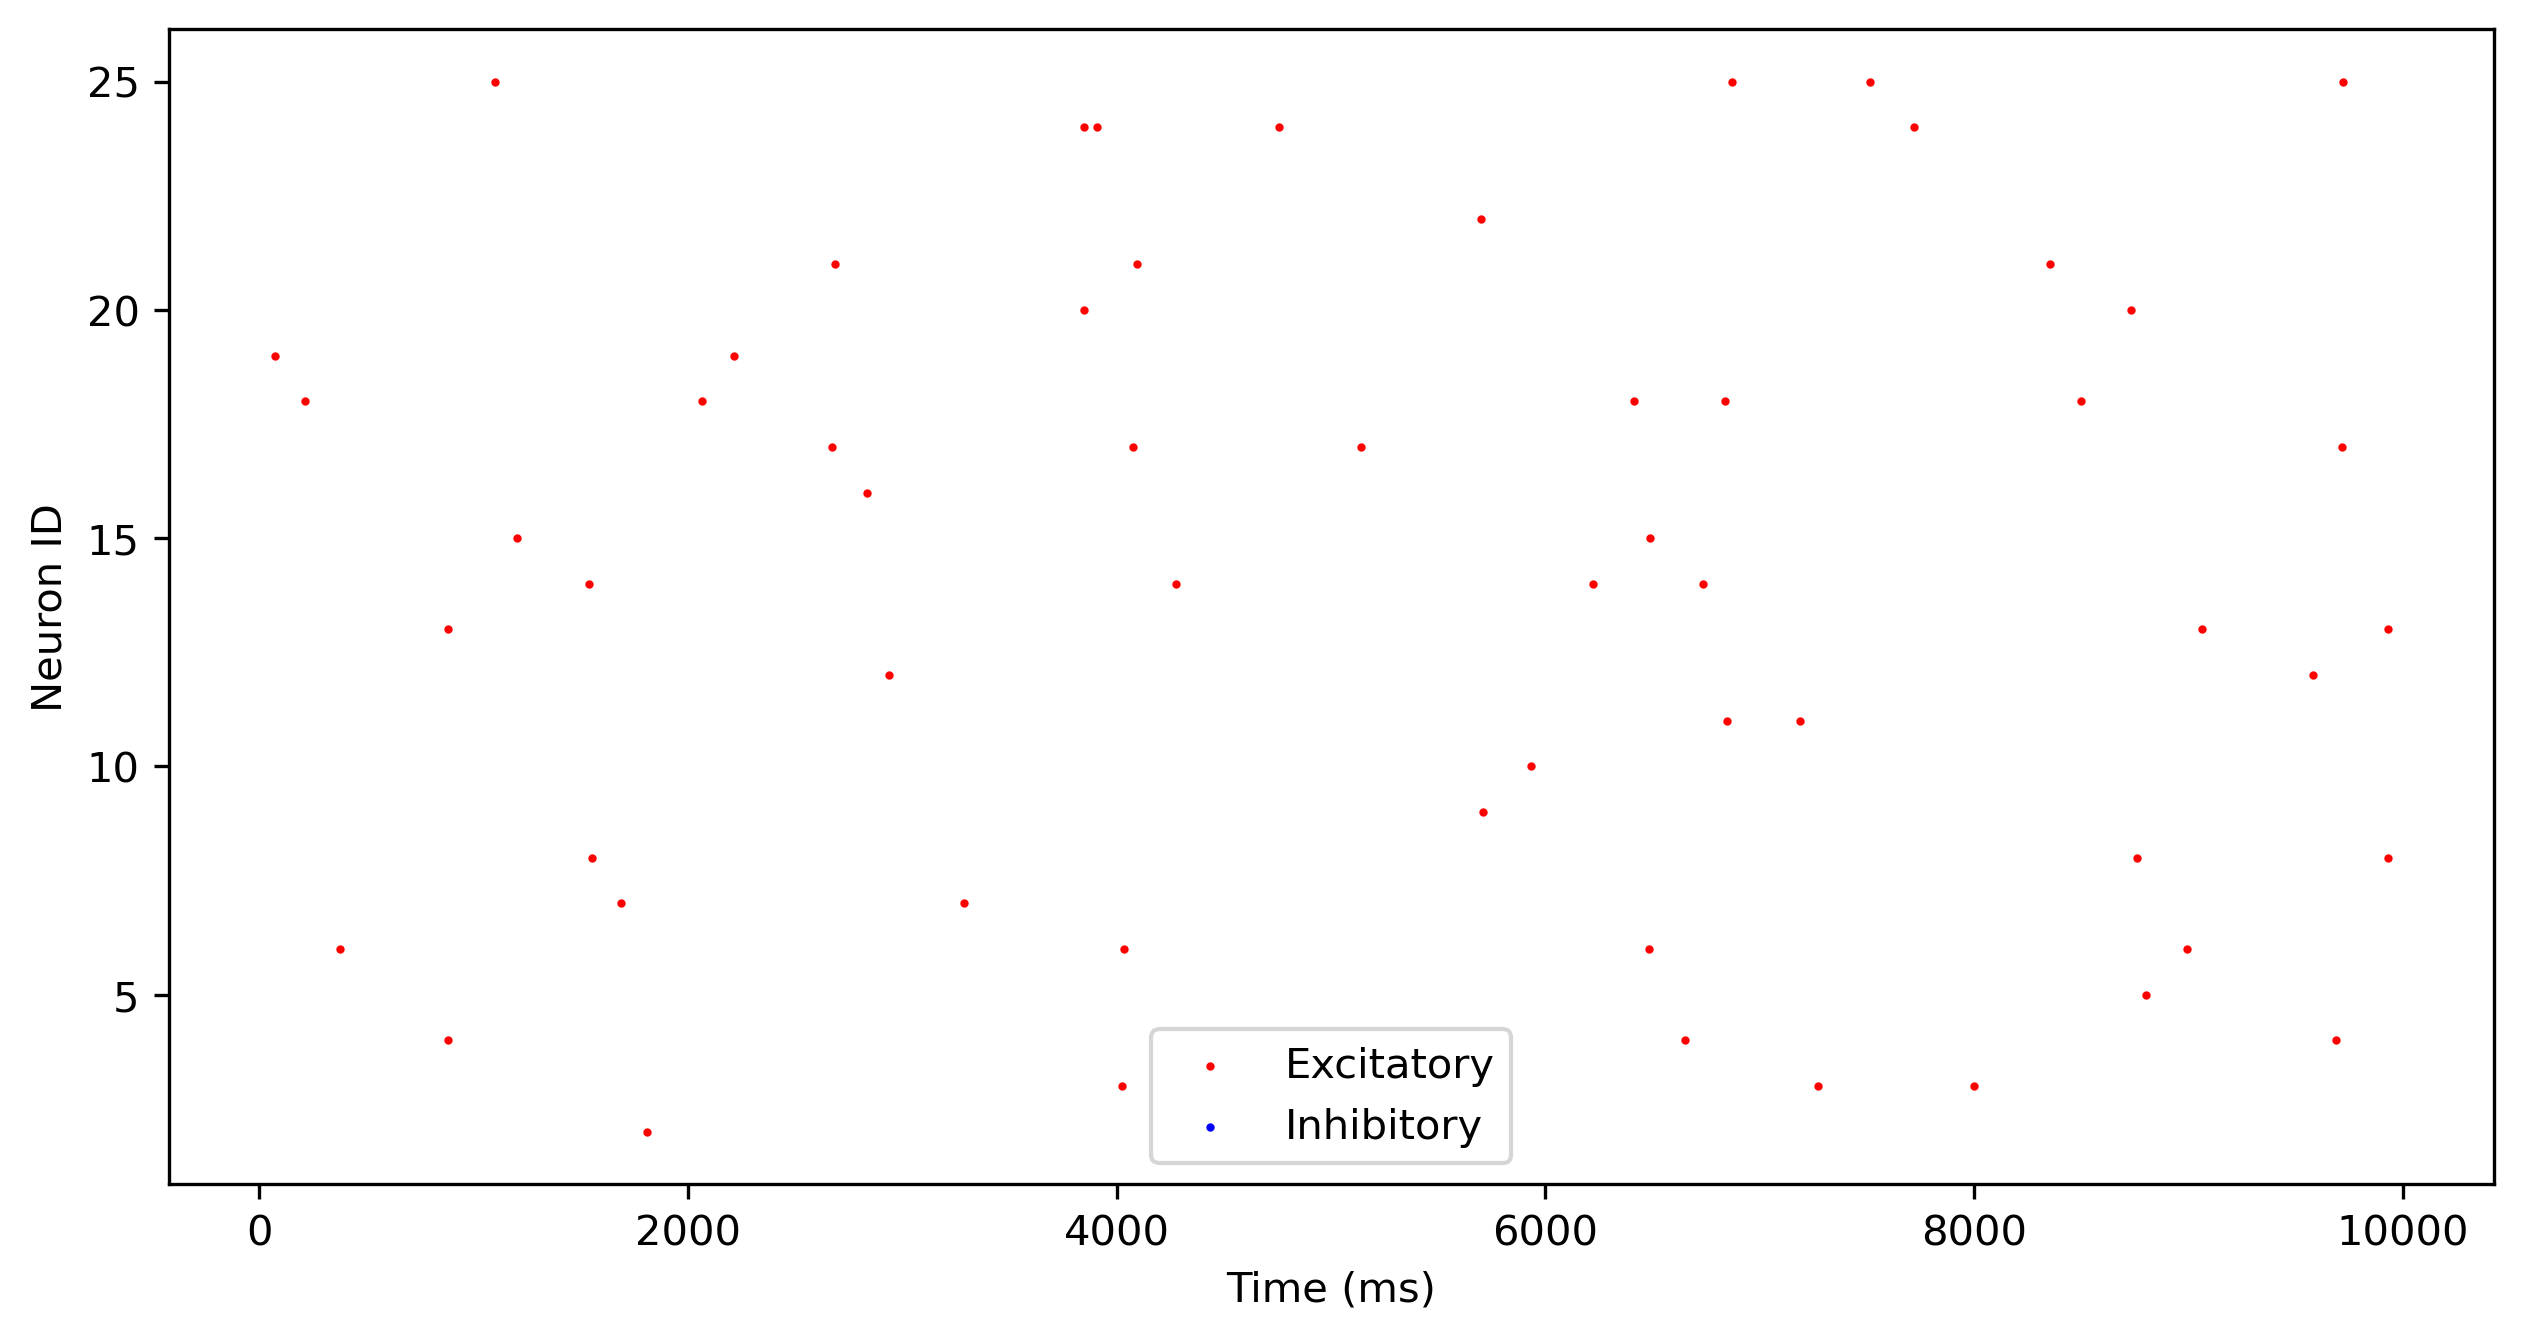

{'senders': array([ 1,  1,  1, ..., 25, 25, 25]), 'times': array([1.0000e-01, 2.0000e-01, 3.0000e-01, ..., 9.9988e+03, 9.9989e+03,
       9.9990e+03]), 'V_m': array([-70.        , -70.        , -70.        , ..., -58.60990794,
       -58.59425501, -58.57886385])}


In [248]:
import time
nest.ResetKernel()
time.sleep(1)

layer_e, layer_i = create_populations()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

connect_pop_base(layer_e, layer_i, fig, (ax1, ax2))

create_patterned_input(layer_e)
# create_thalamic_input(layer_e)

multimeter_e, multimeter_i, sr_e, sr_i = recording_devices(layer_e, layer_i)

# Run simulation (adjust simulation time as needed)
nest.Simulate(10000)

# Plot outputs
plot_pattern_output(sr_e, sr_i, layer_e)
plot_spikes(sr_e, sr_i)

print(multimeter_e.get("events"))

Synapses with STP: 504
Synapses without STP: 100
[[-1.   0.   0.  ...  0.   0.5  0. ]
 [ 0.  -1.  -1.  ...  0.   0.5  0. ]
 [ 0.  -1.  -1.  ...  0.  -1.   0. ]
 ...
 [ 0.   0.   0.  ... -1.   0.  -1. ]
 [ 0.  -1.  -1.  ...  0.5 -1.   0. ]
 [ 0.   0.   0.  ... -1.   0.5 -1. ]]


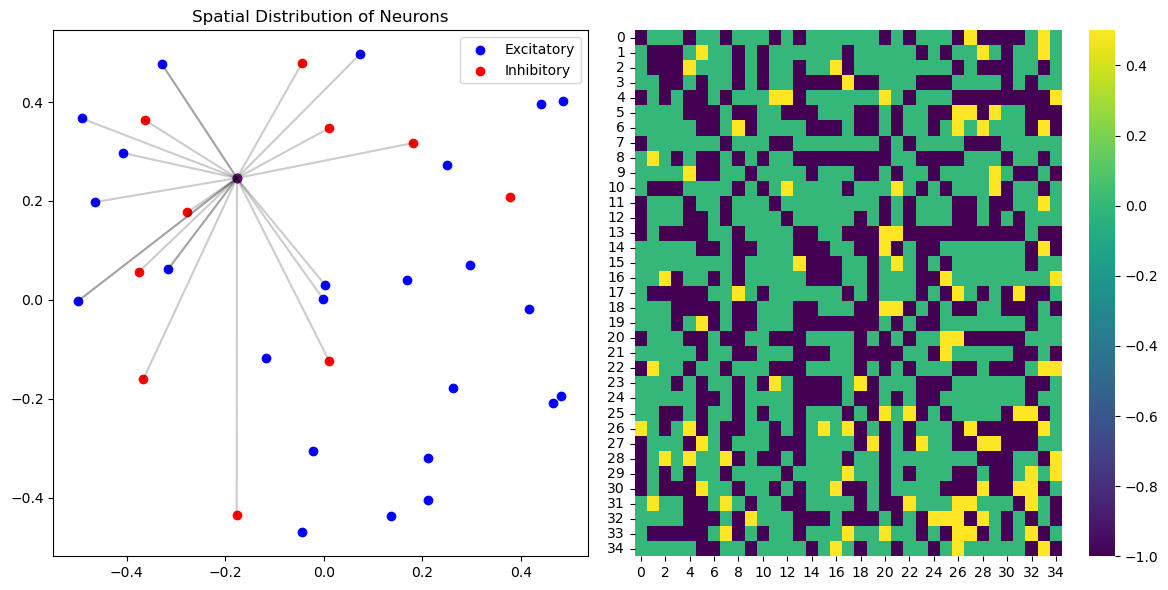

(5, 5)
[[1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]
[ 0  1  5  6 12 13 17 18]
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=1, last=1): Rate = 150.0 Hz
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=2, last=2): Rate = 150.0 Hz
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=3, last=3): Rate = 50.0 Hz
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=4, last=4): Rate = 50.0 Hz
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=5, last=5): Rate = 50.0 Hz
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=6, last=6): Rate = 150.0 Hz
Neuron NodeCollection(metadata=spatial,
               model=exc_iaf_psc_alpha, size=1, first=7, last=7): Rate = 150.0 Hz
Neuron NodeCollection(met

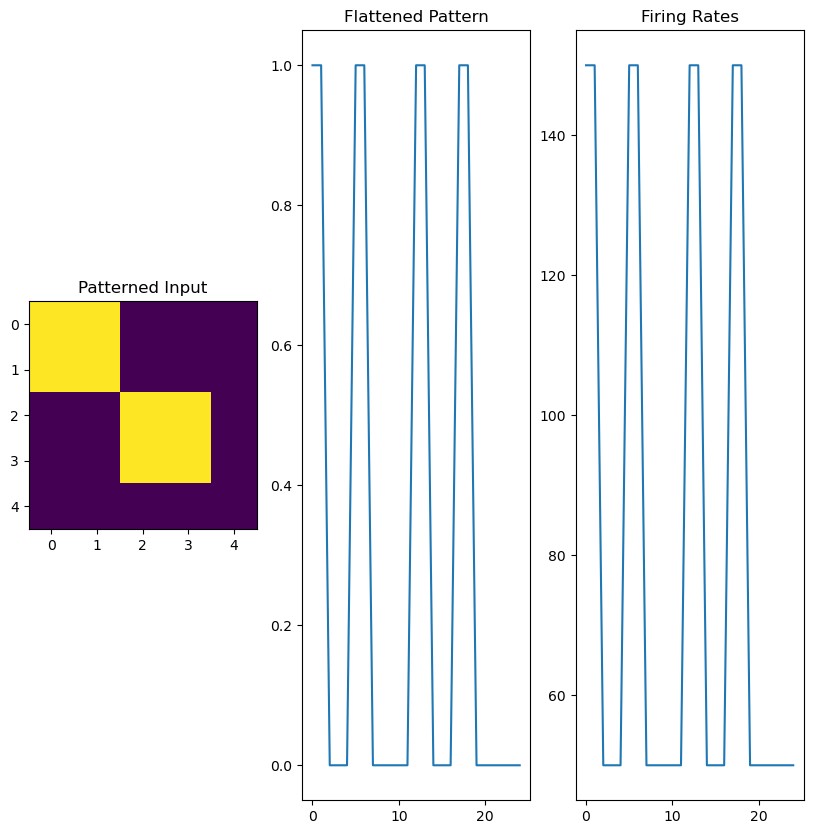


Feb 11 17:57:41 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.

Feb 11 17:57:41 NodeManager::prepare_nodes [Info]: 
    Preparing 64 nodes for simulation.

Feb 11 17:57:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 64
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Feb 11 17:57:42 SimulationManager::run [Info]: 
    Simulation finished.


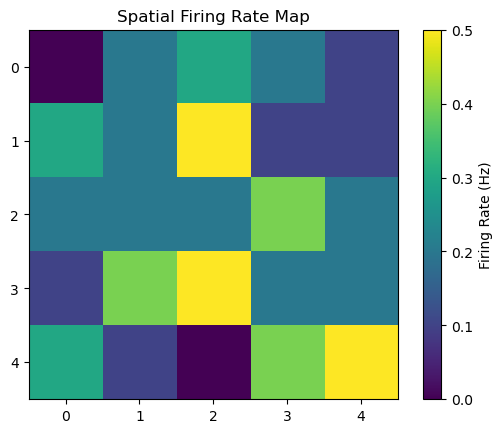

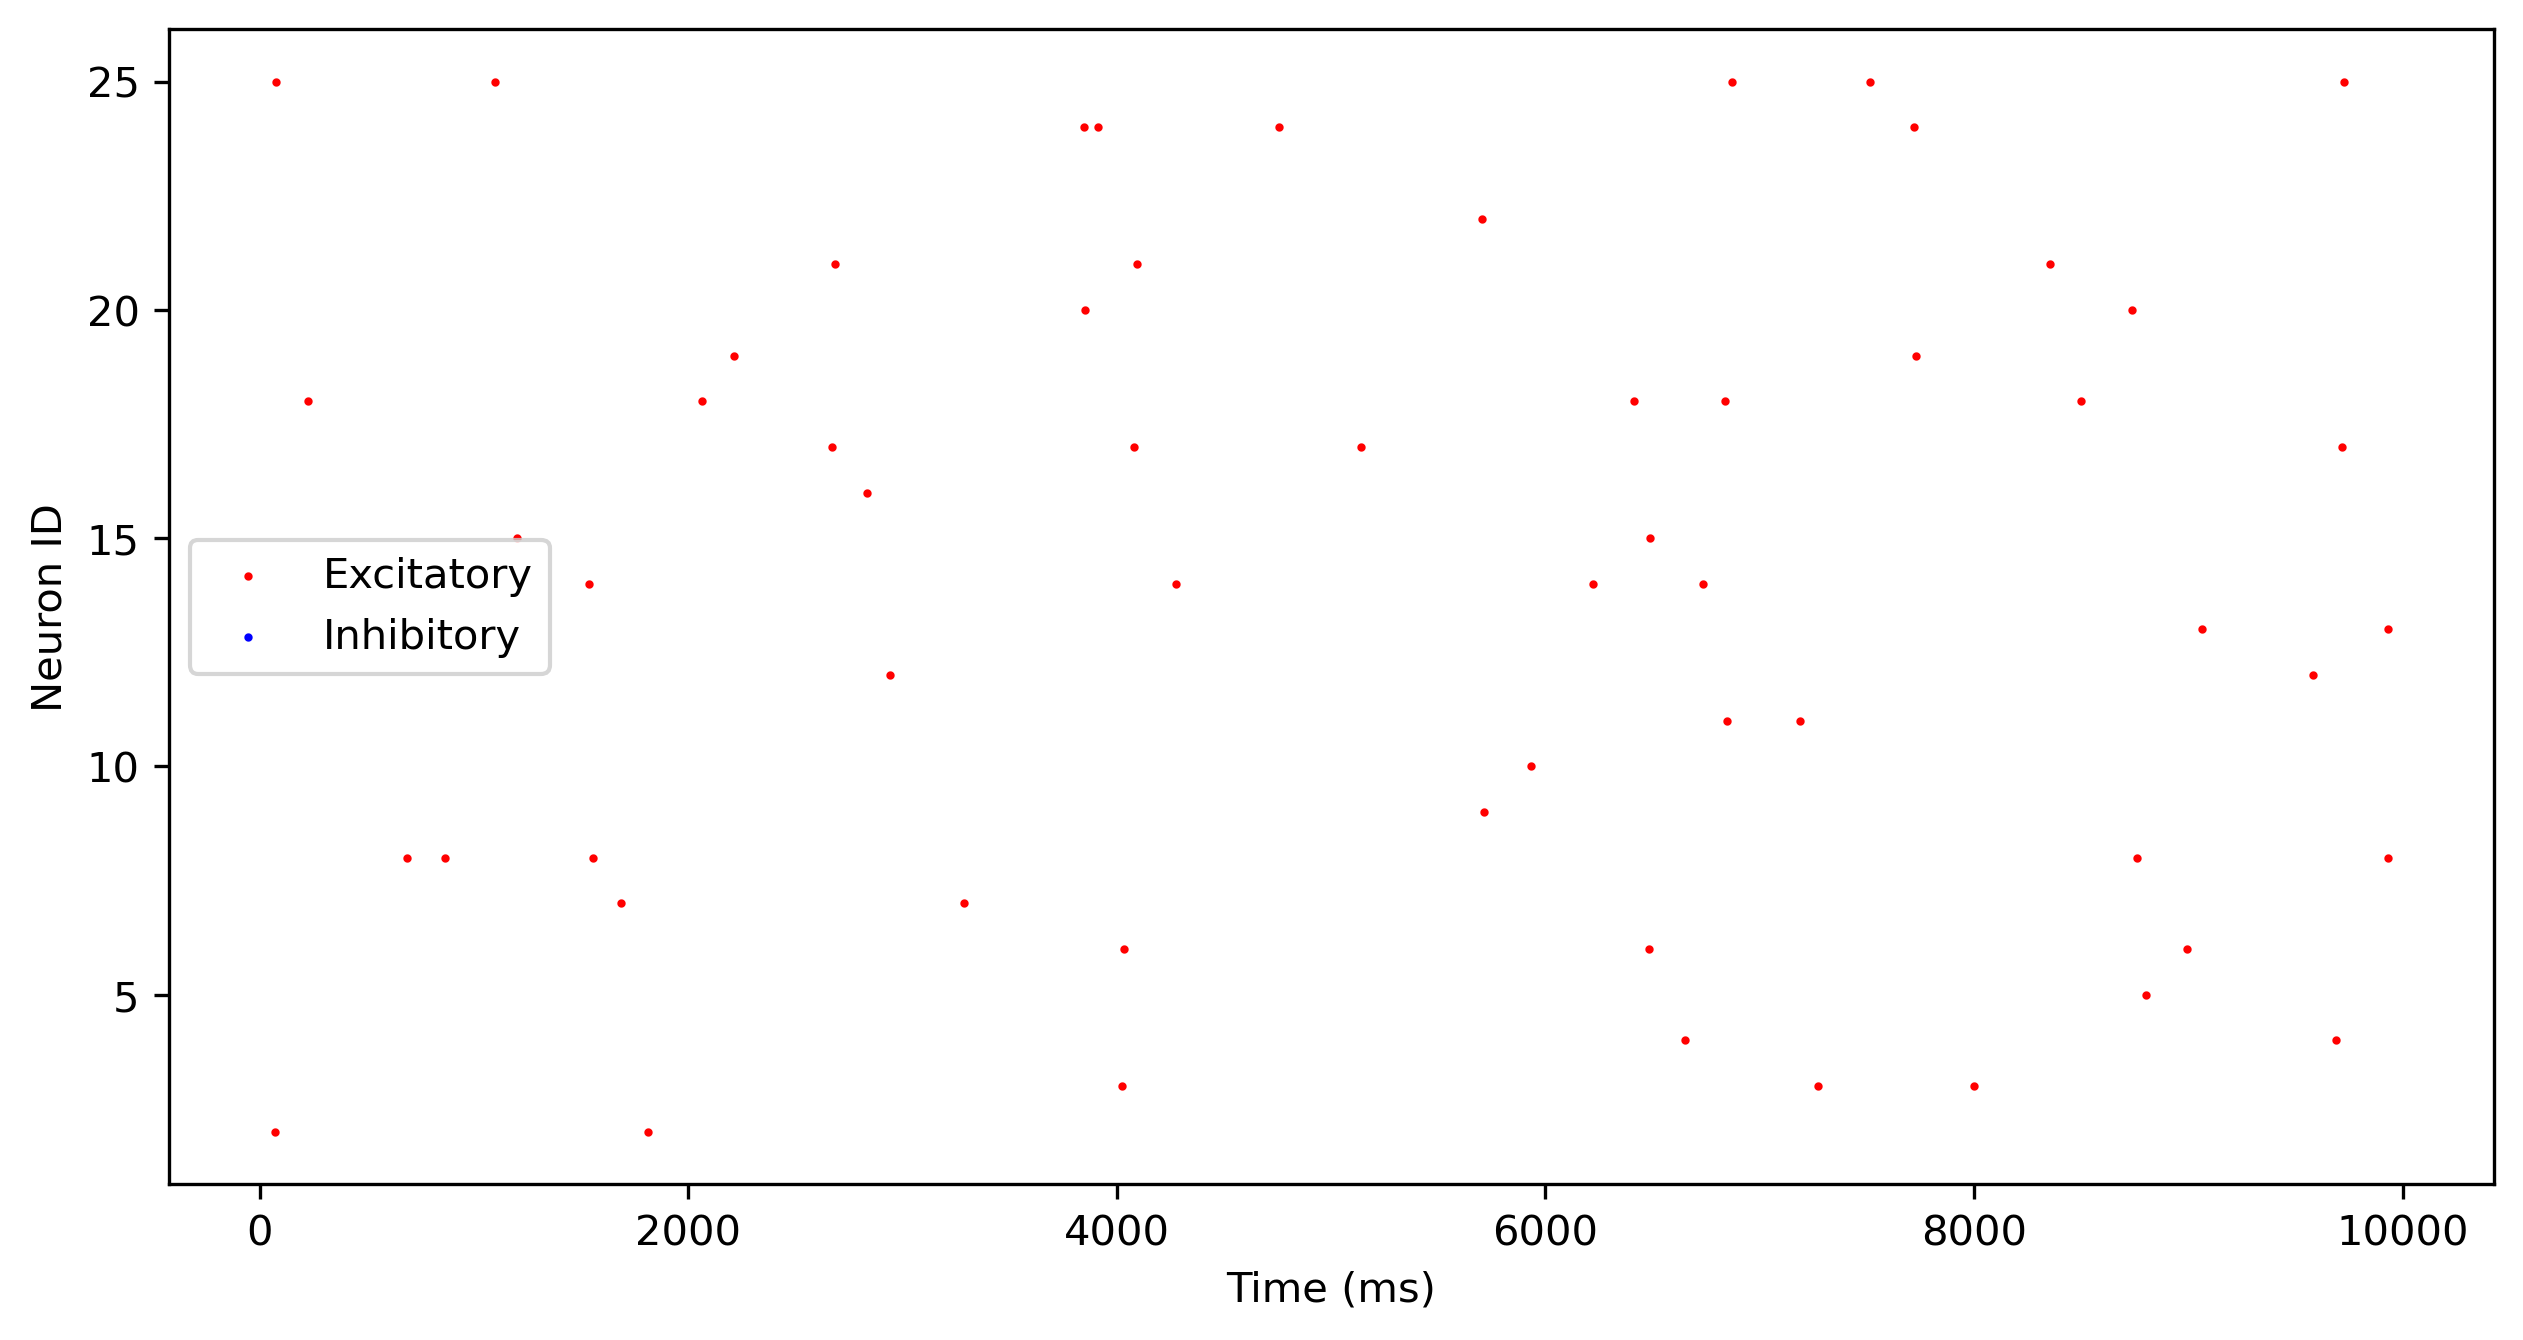

In [235]:
nest.ResetKernel()
time.sleep(1)

layer_e_p, layer_i_p = create_populations()

figP, (ax1P, ax2P) = plt.subplots(1, 2, figsize=(12, 6))

connect_pop_tsodyks(layer_e_p, layer_i_p, figP, (ax1P, ax2P))

create_patterned_input(layer_e_p)
# create_thalamic_input(layer_e)

multimeter_eP, multimeter_iP, sr_eP, sr_iP = recording_devices(layer_e_p, layer_i_p)

# Run simulation (adjust simulation time as needed)
nest.Simulate(10000)

# Plot outputs
plot_pattern_output(sr_eP, sr_iP, layer_e_p)
plot_spikes(sr_eP, sr_iP)


In [ ]:


# monitorConnectionEvolution(layer_e_p, layer_i_p, connection_model=('short_syn','long_syn'), n_connections=2, begin = 0, steps = 50, plots = 3)


TypeError: monitor_synaptic_strength() missing 1 required positional argument: 'synapse_model'

In [ ]:
def run_protocol(network, patterns, trials=5):
    """Test network memory before/after pruning"""
    results = {'original': [], 'pruned': []}
    
    # Original network test
    for _ in range(trials):
        for p in patterns:
            train_network(p, network)
            results['original'].append(measure_reactivation(p))
    
    # Prune long-range connections
    prune_long_range(network)
    
    # Pruned network test
    for _ in range(trials):
        for p in patterns:
            train_network(p, network)
            results['pruned'].append(measure_reactivation(p))
    
    return results

In [12]:
nest.GetDefaults("stdp_synapse")['receptor_type']

0

# Monitoring changes in synapses

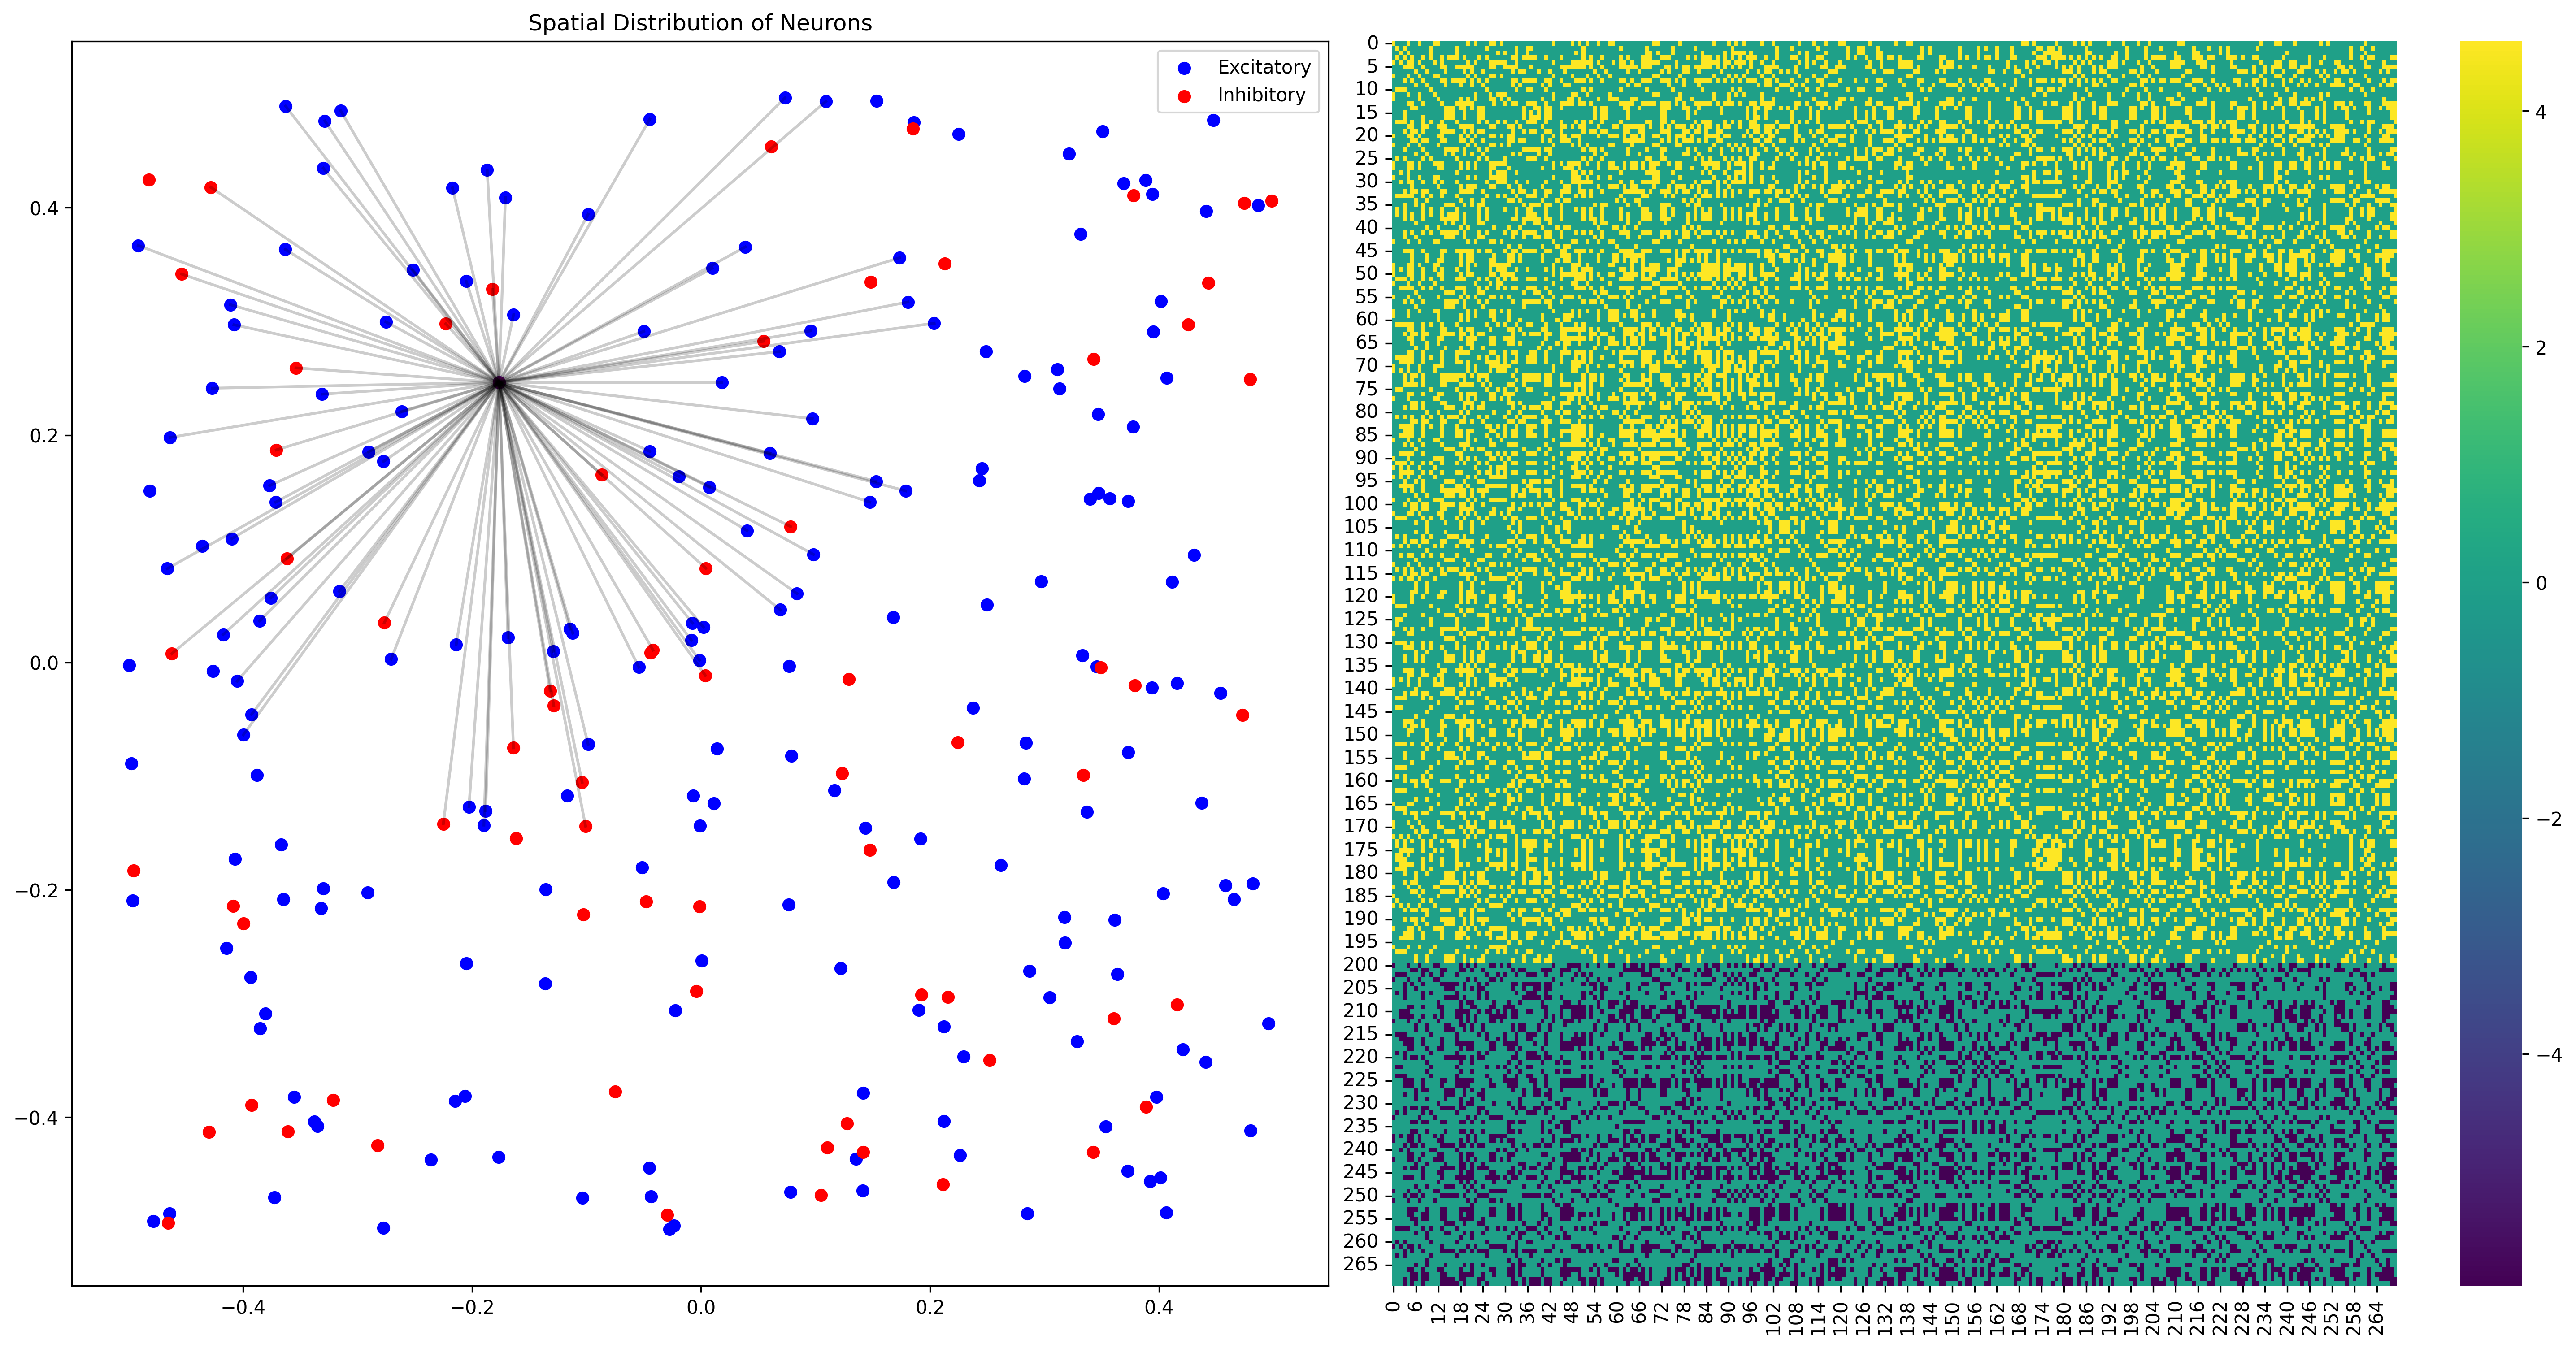

In [5]:
nest.ResetKernel()
layer_e, layer_i = create_populations()
# spatial_distribution(layer_e, layer_i)
create_thalamic_input(layer_e)
m_e, m_i, sr_e, sr_i = recording_devices(layer_e, layer_i)
connect_pop(layer_e, layer_i)

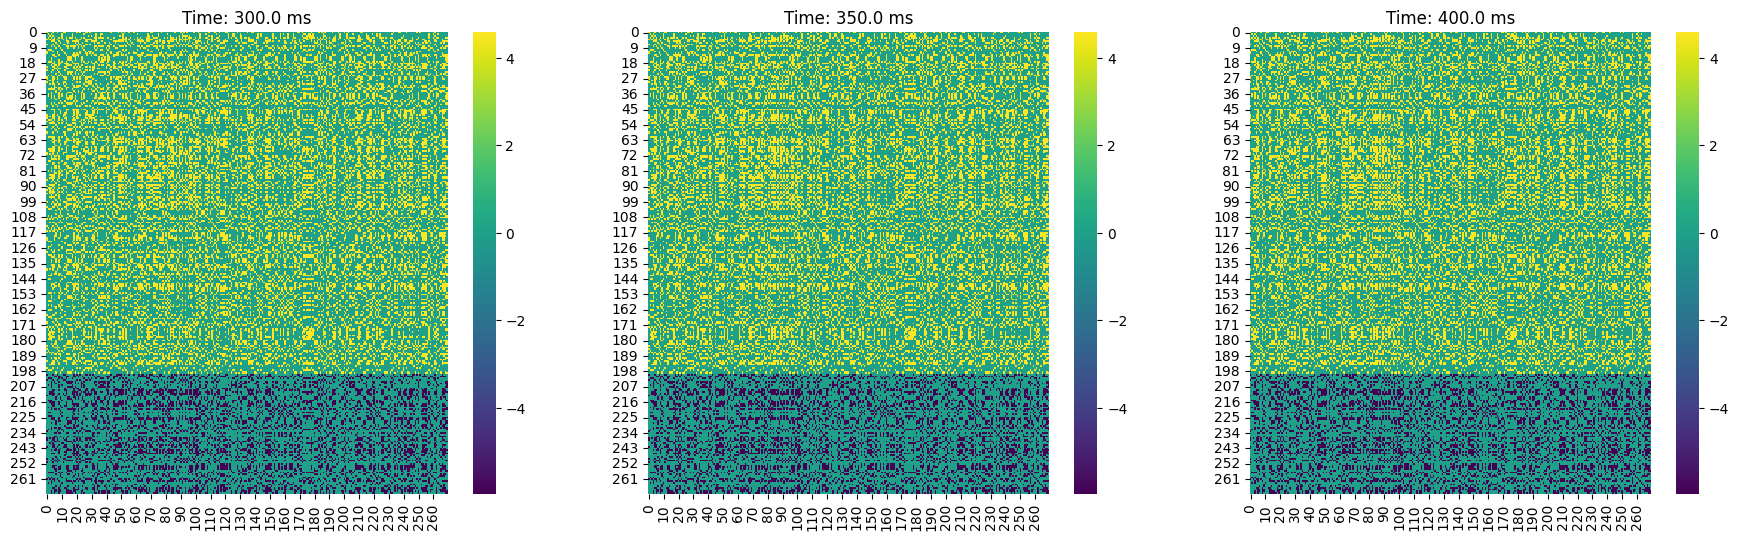

In [6]:
monitorConnectionEvolution(layer_e,layer_i, begin = 250) # this is for stdp synapses